In [20]:
# built-in libraries
import os
import sys
from itertools import combinations
from collections import defaultdict
import time
import pprint
import copy
import pickle
from functools import reduce

# external dependencies
import pandas as pd
pd.set_option('display.max_rows',10)
import seaborn as sns
from scipy.stats import pearsonr
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib.transforms import (
    Bbox, TransformedBbox, blended_transform_factory)
from mpl_toolkits.axes_grid1.inset_locator import (
    BboxPatch, BboxConnector, BboxConnectorPatch)
import matplotlib.patches as patches
import matplotlib.colors as colors
import numpy as np
import scipy as sp
from tqdm.notebook import tqdm
import jax
import jax.numpy as jnp
import shutil
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.PDBList import PDBList
from Bio.PDB.DSSP import DSSP
from Bio import SeqIO
import multidms
%matplotlib inline

from Bio import SeqIO
from Bio.Seq import Seq

import itertools
from itertools import product

import warnings
warnings.simplefilter('ignore')

In [21]:
#get wt sequences at reference positions and store in dataframe

#wildtype sequences, note that sn89 starts later due to the salI cut site being partway through the HA but before the mutated region
geneseq_ussr = 'ATGAAAGCAAAACTACTGGTCCTGTTATGTGCACTTTCAGCTACAGATGCAGACACAATATGTATAGGCTACCATGCGAACAACTCAACCGACACTGTTGACACAGTACTCGAAAAGAACGTGACAGTGACACACTCTGTCAACCTACTTGAGGACAGTCACAACGGAAAACTATGCAGACTAAAAGGAATAGCCCCACTACAATTGGGGAAATGCAACATTGCCGGATGGATCTTAGGAAACCCAGAATGCGAATCACTGTTTTCTAAGAAATCATGGTCCTACATTGCAGAAACACCAAACTCCGAGAATGGAACATGTTACCCAGGATATTTCGCCGACTATGAGGAATTGAGGGAGCAATTGAGCTCAGTATCATCATTCGAGAGATTCGAAATATTCCCCAAGGAAAGATCATGGCCCAAACACAACGTAACCAGAGGCGTAACGGCATCATGCTCCCATAAGGGGAAAAGCAGTTTTTACAGAAATTTGCTATGGCTGACGGAGAAAAATGGCTCGTACCCAAATCTGAGCAAGTCCTATGTGAACAACAAAGAGAAAGAAGTCCTTGTACTATGGGGTGTTCATCACCCGTCAAACATAGAGGACCAAAAGACCATCTATCGGAAAGAAAATGCTTATGTGTCTGTAGTGTCTTCAAATTATAACAGGAGATTCACCCCAGAAATAGCAGAAAGACCCAAAGTAAGAGGTCAAGCAGGGAGAATTAACTACTACTGGACTCTGCTGGAACCCGGGGACACAATAATATTTGAGGCAAATGGAAATCTAATAGCGCCATGGCATGCTTTCGCACTGAATAGAGGCTTTGGGTCAGGAATCATCACCTCAAACGCATCGATGGATGAATGTGACACGAAGTGTCAAACACCCCAGGGAGCTATAAACAGTAGTCTTCCTTTCCAGAATATACACCCAGTCACAATAGGGGAGTGCCCAAAATACGTCAGGAGTACAAAATTGAGGATGGTTACAGGACTAAGGAACATCCCATCCATTCAATCCAGAGGTCTGTTTGGAGCCATTGCCGGTTTCATTGAAGGGGGATGGACTGGAATGATAGATGGATGGTATGGTTATCATCATCAGAATGAACAGGGATCTGGCTATGCTGCGGATCAAAAAAGCACACAAAATGCCATTAACGGGATTACAAACAAGGTGAACTCTGTTATCGAGAAAATGAACACTCAATTCACAGCTGTGGGTAAAGAATTCAACAAATTAGAAAAAAGGATGGAAAACTTAAATAAAAAAGTTGATGATGGATTTCTGGACATTTGGACATATAATGCAGAATTGTTGGTTCTACTGGAAAATGAAAGGACTTTGGATTTTCATGACTCAAATGTGAAGAATCTGTATGAGAAAGTAAAAAGCCAATTAAAGAATAATGCCAAAGAAATAGGAAACGGGTGTTTTGAATTCTACCACAAGTGTAACAATGAATGCATGGAAAGTGTAAAAAATGGAACTTATGACTATCCAAAATATTCAGAGGAATCAAAGTTAAACAGGGAAAAAATTGATGGAGTGAAATTGGAATCAATGGGAGTCTATCAGATTCTGGCGATCTACTCAACTGTCGCCAGTTCACTGGTCCTGCTCGTGTCACTGGGAGCCATCAGCTTCTGGATGTGCAGCAACGGCAGCCTCCAGTGTAGGATTTGCATTTAA'
geneseq_sn = 'GCCCCACTACAATTGGGTAATTGCAGCATTGCCGGATGGATCTTAGGAAACCCAGAATGCGAATCACTGTTTTCTAAGGAATCATGGTCCTACATTGCAGAAACACCAAACTCCGAGAATGGAACATGTTACCCAGGGTATTTCGCCGACTATGAGGAACTGAGGGAGCAATTGAGTTCAGTATCATCATTCGAGAGATTCGAAATATTCCCCAAAGAAAGCTCATGGCCCAACCACACCGTAACCAAAGGAGTAACGGCAGCATGCTCCCATAATGGGAAAAGCAGTTTTTACAGAAATTTGCTATGGCTGACGGAGAAGAATGGCTTGTACCCAAATCTGAGCAAGTCCTATGTAAACAACAAAGAGAAAGAAGTCCTTGTACTATGGGGTGTTCATCACCCGTCAAACATAGGGGACCAAAGGGCCATCTATCATACAGAAAATGCTTATGTGTCTGTAGTGTCTTCACATTATAGCAGGAGATTCACCCCAGAAATAGCAAAAAGACCCAAAGTAAGAGGTCAAGAAGGAAGAATTAACTACTACTGGACTCTGCTGGAACCCGGGGACACAATAATATTTGAGGCAAATGGAAATCTAATAGCGCCATGGTATGCTTTCGCACTGAGTAGAGGCTTTGGGTCAGGAATCATCACCTCAAACGCATCAATGGATGAATGTGACGCGAAGTGTCAAACACCCCAGGGAGCTATAAACAGTAGTCTTCCTTTCCAGAATGTACACCCAGTCACAATAGGAGAGTGTCCAAAGTATGTCAGGAGTACAAAATTAAGGATGGTTACAGGACTAAGGAACATCCCATCCGTTCAATCCAGAGGTTTGTTTGGAGCCATTGCCGGTTTCATTGAAGGGGGGTGGACTGGAATGATAGATGGATGGTATGGTTATCATCATCAAAATGAACAAGGATCTGGCTATGCTGCGGATCAAAAAAGCACACAAAATGCCATTAACGGGATTACAAACAAGGTGAATTCTGTAATCGAGAAAATGAACACTCAATTCACAGCTGTGGGCAAAGAATTCAACAAATTAGAAAGAAGGATGGAAAACTTAAATAAAAAAGTTGATGATGGATTTCTGGACATTTGGACATATAATGCAGAATTGTTGGTTCTACTGGAAAATGAAAGGACTTTGGATTTTCATGACTCAAATGTGAAGAATCTGTATGAGAAAGTAAAAAGCCAATTAAAGAATAATGCCAAAGAAATAGGAAACGGGTGTTTTGAATTCTACCACAAGTGTAACAATGAATGCATGGAAAGTGTGAAAAATGGAACTTATGACTATCCAAAATATTCCGAGGAATCAAAGTTAAACAGGGAAAAAATTGATGGAGTGAAATTGGAATCAATGGGAGTCTATCAGATTCTGGCGATCTACTCAACTGTCGCCAGTTCACTGGTCCTGCTCGTGTCACTGGGAGCCATCAGCTTCTGGATGTGCAGCAACGGCAGCCTCCAGTGTAGGATTTGCATTTAA'
geneseq_si = 'ATGAAAGTAAAACTACTGGTTCTGTTATGCACATTTACAGCTACATATGCAGACACAATATGTATAGGCTACCATGCCAACAACTCAACCGACACTGTTGACACAGTACTTGAGAAGAATGTGACAGTGACACACTCTGTCAACCTGCTTGAGGACAGTCACAATGGAAAATTATGTCTATTAAAAGGAATAGCCCCACTACAATTGGGTAATTGCAGCGTTGCCGGATGGATCTTAGGAAACCCAGAATGCGAATTACTGATTTCCAGGGAATCATGGTCCTACATTGTAGAAAAACCAAATCCTGAGAATGGAACATGTTACCCAGGGCATTTCGCCGACTATGAGGAACTGAGGGAGCAATTGAGTTCAGTATCTTCATTTGAGAGATTCGAAATATTCCCCAAAGAAAGCTCATGGCCCAACCACACCACAACCGGAGTATCAGCATCATGCTCCCATAATGGGGAAAGCAGTTTTTACAAAAATTTGCTATGGCTGACGGGGAAGAATGGTTTGTACCCAAACCTGAGCAAGTCCTATGCAAACAACAAAGAGAAAGAAGTCCTTGTACTATGGGGTGTTCATCACCCGCCTAACATAGGTGACCAAAGGGCTCTCTATCATACAGAAAATGCTTATGTGTCTGTAGTGTCTTCACATTATAGCAGAAAATTCACCCCAGAAATAGCCAAAAGACCCAAAGTAAGAGATCAAGAAGGAAGAATCAACTACTACTGGACTCTACTTGAACCCGGGGATACAATAATATTTGAGGCAAATGGAAATCTAATAGCGCCAAGATATGCTTTCGCACTGAGTAGAGGCTTTGGATCAGGAATCATCAACTCAAATGCACCAATGGATGAATGTGATGCGAAGTGCCAAACACCTCAGGGAGCTATAAACAGCAGTCTTCCTTTCCAGAATGTACACCCTGTCACAATAGGAGAGTGTCCAAAGTATGTCAGGAGTGCAAAATTAAGGATGGTTACAGGACTAAGGAACATCCCATCCATTCAATCCAGAGGTTTGTTTGGAGCCATTGCCGGTTTCATTGAAGGGGGGTGGACTGGAATGGTAGATGGTTGGTATGGTTATCATCATCAGAATGAGCAAGGATCTGGCTATGCTGCAGATCAAAAAAGCACACAAAATGCCATTAATGGGATTACAAACAAGGTGAATTCTGTAATTGAGAAAATGAACACTCAATTCACAGCTGTGGGCAAAGAATTCAACAAATTGGAAAGAAGGATGGAAAACTTAAATAAAAAAGTTGATGATGGGTTTATAGACATTTGGACATATAATGCAGAATTGTTGGTTCTACTGGAAAATGAAAGGACTTTGGATTTCCATGACTCCAATGTGAAGAATCTGTATGAGAAAGTAAAAAGCCAATTAAAGAATAATGCCAAAGAAATAGGAAATGGGTGTTTTGAATTCTATCACAAGTGTAACGATGAATGCATGGAGAGTGTAAAAAATGGAACTTATGACTATCCAAAATATTCCGAAGAATCAAAGTTAAACAGGGAGAAAATTGATGGAGTGAAATTGGAATCAATGGGAGTCTATCAGATTCTGGCGATCTACTCAACAGTCGCCAGTTCTCTGGTCCTGCTCGTGTCACTGGGAGCCATCAGCTTCTGGATGTGCAGCAACGGCAGCCTCCAGTGTAGGATTTGCATTTAA'
geneseq_syd = 'ATGAAGGCAATACTAGTAGTTATGCTGTATACATTTACAACCGCAAATGCAGACACATTATGTATAGGTTATCATGCGAACAATTCAACAGACACTGTGGACACAGTACTAGAAAAGAATGTAACAGTAACACACTCTGTCAATCTTCTAGAAGACAAGCATAACGGAAAACTATGCAAACTAAGAGGGGTAGCCCCATTGCATTTGGGTCAATGTAACATTGCTGGCTGGATCCTGGGAAATCCAGAGTGTGAATCACTCTCCACAGCAAGATCATGGTCCTACATTGTGGAAACATCTAATTCAGACAATGGAACGTGTTACCCAGGAAATTTCATCAATTATGAGGAGCTAAGAGAGCAATTGAGCTCAGTGTCATCATTTGAAAGGTTTGAAATATTCCCCAAGACAAGTTCATGGCCTAATCATGACTCGGACAATGGTGTAACGGCAGCATGTCCTCACGCTGGAGCAAAAAGCTTCTACAAAAACTTGATATGGCTGGTTAAAAAAGGAAAATCATACCCAAAGATCAACCAAACCTACATTAATGATAAAGGGAAAGAAGTCCTCGTGCTGTGGGGCATTCACCATCCACCTACTATTACTGACCAAGAAAGTCTCTATCAGAATGCAGATGCATATGTTTTTGTGGGGACATCAAGATACAGCAAGAAGTTCAAGCCGGAAATAGCAGCAAGACCCAAAGTGAGGGATCAAGCAGGGAGAATGAACTATTACTGGACACTAGTAGAACCGGGAGATAAAATAACATTCGAAGCAACTGGTAATCTAGTGGCACCGAGATATGCATTCACAATGGAAAAAGATGCTGGATCTGGTATTATCATTTCAGATACACCAGTCCACGATTGCAATACAACTTGTCAGACACCCGAGGGTGCTATAAACACCAGCCTCCCATTTCAGAATGTACATCCGATCACGATTGGGAAATGTCCAAAGTATGTAAGAAGCACAAAATTGAGACTGGCCACAGGATTGAGGAATGTCCCGTCTATTCAATCTAGAGGCCTATTCGGGGCCATTGCTGGCTTCATCGAAGGGGGGTGGACAGGGATGGTAGATGGATGGTACGGTTATCACCATCAAAATGAGCAGGGGTCAGGATATGCAGCCGATCTGAAGAGCACACAAAATGCCATTGATAAGATTACCAACAAAGTAAATTCTGTCATTGAAAAGATGAATACACAGTTCACAGCAGTTGGTAAAGAGTTCAACCACCTTGAAAAAAGAATAGAGAATCTAAATAAAAAGGTTGATGATGGTTTCCTGGACATTTGGACTTACAATGCCGAACTGTTGGTTCTACTGGAAAACGAAAGAACTTTGGACTATCACGATTCAAATGTGAAGAACTTGTATGAAAAAGTAAGAAACCAGTTAAAAAACAATGCCAAGGAAATTGGAAACGGCTGCTTTGAATTTTACCACAAATGCGACAACACATGCATGGAAAGTGTCAAGAATGGGACTTATGACTACCCAAAATACTCAGAGGAAGCAAAATTAAACAGAGAAAAAATAGATGGAGTAAAGCTGGACTCAACAAGGATTTACCAGATTTTGGCAATCTATTCAACTGTTGCCAGTTCATTGGTCCTGGTCGTGTCACTGGGAGCCATCAGCTTCTGGATGTGCAGCAACGGCAGCCTCCAGTGTAGGATTTGCATTTAA'

geneseq_dict = {'USSR77':geneseq_ussr,
                'SN89':geneseq_sn,
                'SI06':geneseq_si,
                'SYD21':geneseq_syd}

condition_list = []
wt_aa_res_list = []
sequential_position_list = []

for bkg in geneseq_dict:
    wt_nt_seq = Seq(geneseq_dict[bkg])
    wt_aa_seq = wt_nt_seq.translate()
    for pos in range(len(wt_aa_seq)):
        pos += 1
        wt_aa_res = wt_aa_seq[pos-1:pos]
        condition_list.append(bkg)
        wt_aa_res_list.append(str(wt_aa_res))
        sequential_position_list.append(pos)

wt_aa_df = pd.DataFrame()
wt_aa_df['condition']=condition_list
wt_aa_df['wt_aa']=wt_aa_res_list
wt_aa_df['sequential_site']=sequential_position_list

background_list=['USSR77','SN89','SI06','SYD21']

renumber_df = pd.DataFrame()

for bkg in background_list:
    temp_df = pd.read_csv(f'data/renumbering_files/{bkg}_renumber.csv')
    temp_df['condition'] = bkg
    cols = ['condition','sequential_site','reference_site']
    temp_df = temp_df[cols]
    renumber_df = pd.concat([renumber_df,temp_df])
    
wt_aa_df = wt_aa_df.merge(renumber_df,on=['condition','sequential_site'],how='inner')
wt_aa_df

,condition,wt_aa,sequential_site,reference_site
0,USSR77,M,1,-12
1,USSR77,K,2,-11
2,USSR77,A,3,-10
3,USSR77,K,4,-9
4,USSR77,L,5,-8
...,...,...,...,...
2198,SYD21,R,563,549
2199,SYD21,I,564,550
2200,SYD21,C,565,551
2201,SYD21,I,566,552


In [22]:
background_list=['USSR77','SN89','SI06','SYD21']
replicate_list=['R1','R2','all']
cols=['condition','aa_substitutions','replicate','func_score','n_aa_substitutions']

func_score_df=pd.DataFrame()

for bkg in background_list:
    for rep in replicate_list:
        temp_df = pd.read_csv(f'data/func_scores/{bkg}_{rep}.csv')
        temp_df['condition'] = f'{bkg}'
        if rep == 'all':
            temp_df['library'] = 'all'
        temp_df = temp_df.rename(columns={'aa_substitutions_reference':'aa_substitutions','library':'replicate'})
        temp_df = temp_df[cols]
        func_score_df=pd.concat([func_score_df,temp_df])

lower_bound = -1000
upper_bound = 1000
func_score_df['func_score'] = func_score_df['func_score'].clip(lower_bound, upper_bound)
func_score_df = func_score_df.fillna('')

func_score_df

,condition,aa_substitutions,replicate,func_score,n_aa_substitutions
0,USSR77,N91A,rep1,0.021683,1
1,USSR77,N91P,rep1,-2.610363,1
2,USSR77,N187-,rep1,-7.100528,1
3,USSR77,S126Y,rep1,-7.656534,1
4,USSR77,R106N,rep1,-4.880541,1
...,...,...,...,...,...
4933,SYD21,I169E S312I,all,-3.548500,2
4934,SYD21,A52I L66P,all,-0.079441,2
4935,SYD21,P140Q W180R,all,-1.161383,2
4936,SYD21,V112L D263K,all,-0.309228,2


In [23]:
func_score_reps = func_score_df.pivot_table(columns='replicate',index=['condition','aa_substitutions'],values=['func_score','n_aa_substitutions']).reset_index().dropna()
func_score_reps.columns = func_score_reps.columns.to_series().str.join('_')
func_score_reps = func_score_reps.rename(columns={'condition_':'condition','aa_substitutions_':'aa_substitutions','n_aa_substitutions_all':'n_aa_substitutions','func_score_all':'func_score'})
func_score_reps = func_score_reps[['condition','aa_substitutions','func_score_rep1','func_score_rep2','func_score','n_aa_substitutions']]
func_score_reps

,condition,aa_substitutions,func_score_rep1,func_score_rep2,func_score,n_aa_substitutions
0,SI06,,-0.038663,0.052464,0.005882,0.0
3,SI06,A100C,-5.132123,-4.565273,-4.836361,1.0
4,SI06,A100D,-8.108204,0.783314,-0.183764,1.0
9,SI06,A100E,-7.072033,-5.120371,-5.775384,1.0
10,SI06,A100F,-6.588550,-6.199455,-6.377844,1.0
...,...,...,...,...,...,...
21691,USSR77,Y98R,0.237319,-2.498841,-0.823622,1.0
21692,USSR77,Y98S,-1.256462,-0.958837,-1.010641,1.0
21693,USSR77,Y98T,0.184136,1.273698,0.608539,1.0
21694,USSR77,Y98V,0.247541,0.257548,0.278183,1.0


In [24]:
def assign_mut_type(row):
    if row['n_aa_substitutions']==0.0:
        return 'synonymous'
    elif row['n_aa_substitutions']>1:
        return 'multi_mut'
    elif row['n_aa_substitutions'] == 1 and '*' in row['aa_substitutions']:
        return 'stop'
    elif row['n_aa_substitutions'] == 1 and '-' in row['aa_substitutions']:
        return 'deletion'
    else:
        return 'non-synonymous'
    
func_score_reps['mut_type']=func_score_reps.apply(lambda row: assign_mut_type(row), axis=1)
func_score_reps['difference']=abs(func_score_reps['func_score_rep2']-func_score_reps['func_score_rep1'])
func_score_reps['func_score_mean']=func_score_reps[['func_score_rep1','func_score_rep2']].mean(axis=1)
func_score_reps['func_score_sem']=func_score_reps[['func_score_rep1','func_score_rep2']].sem(axis=1)
func_score_reps['mut']=func_score_reps['aa_substitutions'].str[1:]
func_score_df['mut_type']=func_score_df.apply(lambda row: assign_mut_type(row), axis=1)
func_score_singles = func_score_df.query(" mut_type != 'multi-mut'")
func_score_singles['mut']=func_score_singles['aa_substitutions'].str[1:]
func_score_singles['wt_res']=func_score_singles['aa_substitutions'].str[0:1]
func_score_singles['position']=func_score_singles['aa_substitutions'].str[1:-1]


func_score_reps.head()

,condition,aa_substitutions,func_score_rep1,func_score_rep2,func_score,n_aa_substitutions,mut_type,difference,func_score_mean,func_score_sem,mut
0,SI06,,-0.038663,0.052464,0.005882,0.0,synonymous,0.091127,0.006900,0.045563,
3,SI06,A100C,-5.132123,-4.565273,-4.836361,1.0,non-synonymous,0.566850,-4.848698,0.283425,100C
4,SI06,A100D,-8.108204,0.783314,-0.183764,1.0,non-synonymous,8.891518,-3.662445,4.445759,100D
9,SI06,A100E,-7.072033,-5.120371,-5.775384,1.0,non-synonymous,1.951662,-6.096202,0.975831,100E
10,SI06,A100F,-6.588550,-6.199455,-6.377844,1.0,non-synonymous,0.389094,-6.394003,0.194547,100F


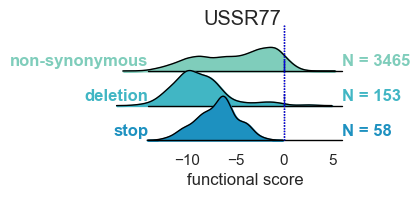

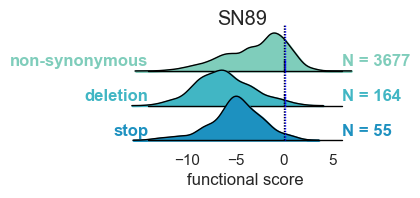

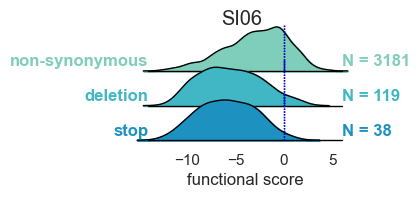

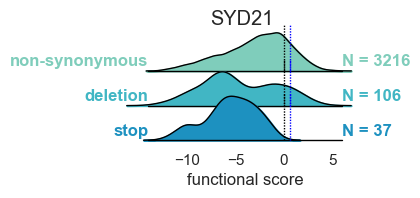

In [33]:
#this generates the distirbution plots of functional scores by virus background and mutation type

background_list=['USSR77','SN89','SI06','SYD21']
smoothing_factor = 0.8 #lower the number, the less smoothing, this is a float
aspect_ratio = 5 #essentially controls width/length of plots, higher number is wider

for bkg in background_list:

    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    # Create the data
    df = func_score_reps.query(f"condition=='{bkg}' & mut_type!='synonymous' & mut_type!='multi_mut' ")
    
    # get synonymous mutations functional score
    syn_func_score = func_score_reps.query(f"condition == '{bkg}' & mut_type == 'synonymous' ")['func_score'].iat[0]
    
    # Get counts of each mut type
    non_syn_counts = func_score_reps.query(f"condition == '{bkg}' & mut_type == 'non-synonymous' ")['aa_substitutions'].nunique()
    deletion_counts = func_score_reps.query(f"condition == '{bkg}' & mut_type == 'deletion' ")['aa_substitutions'].nunique()
    stop_counts = func_score_reps.query(f"condition == '{bkg}' & mut_type == 'stop' ")['aa_substitutions'].nunique()

    # Initialize the FacetGrid object
    pal = ['#7fcdbb','#41b6c4','#1d91c0']
    df = df.rename(columns={'func_score':'functional score'})
    #pal = sns.cubehelix_palette(10, rot=-.25, light=.4)
    g = sns.FacetGrid(df, row="mut_type", row_order=['non-synonymous','deletion','stop'],
                      hue='mut_type', hue_order = ['non-synonymous','deletion','stop'],
                      aspect=aspect_ratio, height=.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "functional score",
          bw_adjust=smoothing_factor, clip_on=False,
          fill=True, alpha=1, linewidth=1.5, common_norm=False)
    g.map(sns.kdeplot, "functional score", clip_on=False, color="black", lw=1, bw_adjust=smoothing_factor)

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=1, linestyle="-", color='black', clip_on=False)
    g.refline(x=0, linewidth=1, linestyle="-", color='black', clip_on=False, dashes=(1,1))
    g.refline(x=syn_func_score,linewidth=1, linestyle="-", color='blue', clip_on=False, dashes=(1,1))



    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="right", va="center", transform=ax.transAxes)

        
    

    g.map(label, "functional score")
    #g.map(label_n, "func_score")
    
    ax = plt.gca()
    hplacement = 1
    ax.text(hplacement, 1.7, f"N = {non_syn_counts}", fontweight="bold", color=pal[0],
                ha="left", va="center", transform=ax.transAxes)
    ax.text(hplacement, 0.95, f"N = {deletion_counts}", fontweight="bold", color=pal[1],
                ha="left", va="center", transform=ax.transAxes)
    ax.text(hplacement, 0.2, f"N = {stop_counts}", fontweight="bold", color=pal[2],
                ha="left", va="center", transform=ax.transAxes)

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-0.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)
    g.savefig(f'plots/{bkg}_func_score_distribution_plot.png')
    g.fig.suptitle(bkg)
    g.set(xlim=(-14, 6))

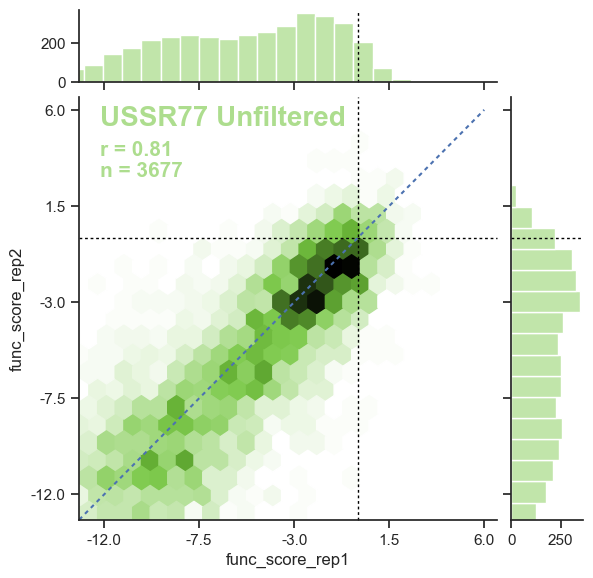

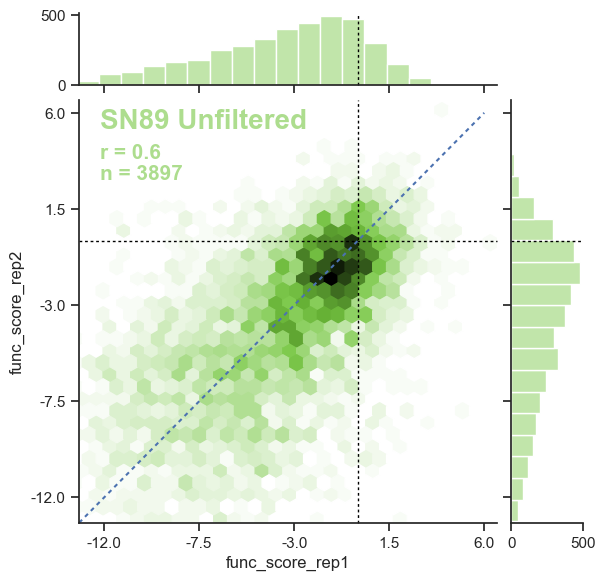

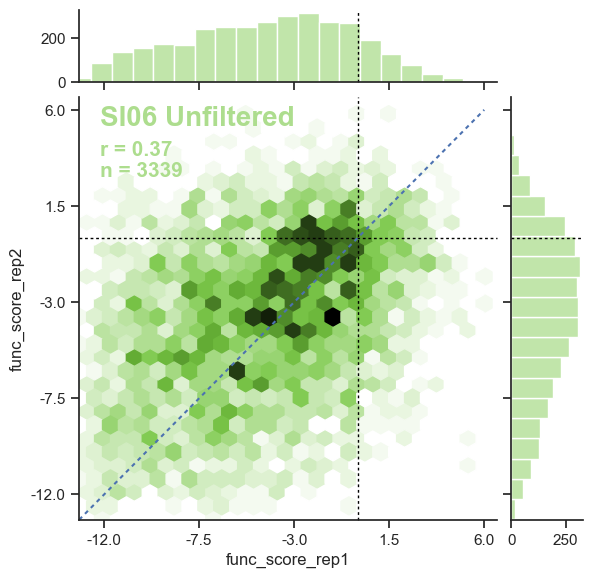

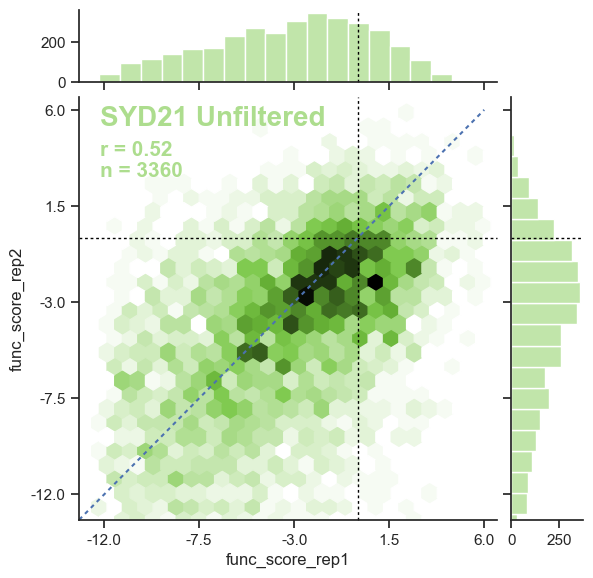

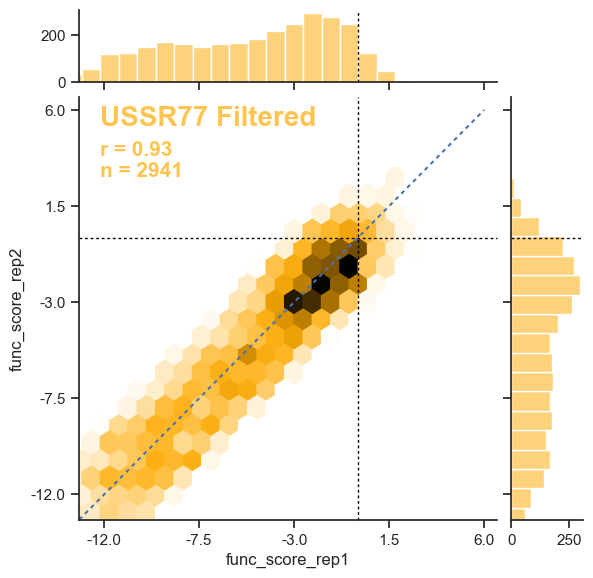

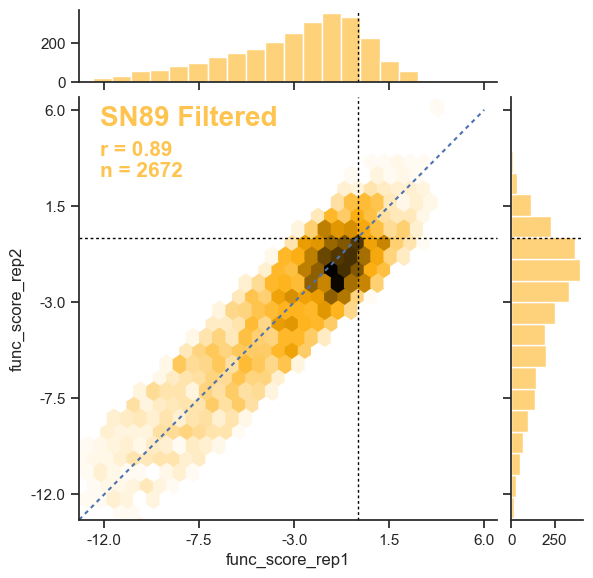

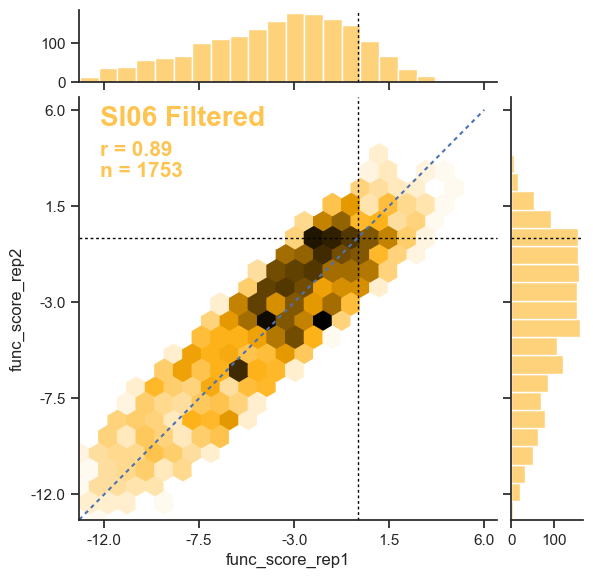

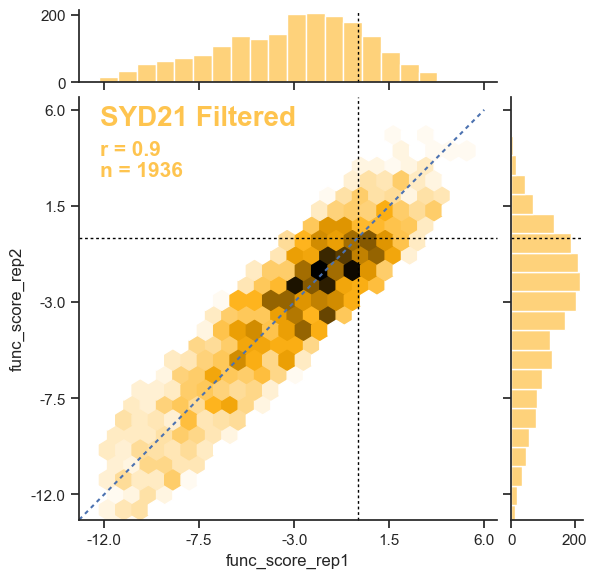

In [26]:
background_list=['USSR77','SN89','SI06','SYD21']
difference_filter = 3

fig_list=[]

lower_bound = -12
upper_bound = 6

limits = [lower_bound+lower_bound/10, upper_bound+upper_bound/10]
ticks = np.linspace(lower_bound, upper_bound, 5)

pal=['#addd8e','#fec44f']

for bkg in background_list:
    #set colors from pal
    color = pal[0]
    
    #get data for background
    df = func_score_reps.query(f" condition == '{bkg}' ")
    
    #calculate pearson coefficient
    r, p = sp.stats.pearsonr(x=df['func_score_rep1'], y=df['func_score_rep2'])
    r = round(r,2)
    
    #turn on ticks
    sns.set_theme(style="ticks")
    
    #get number of single mutant variants
    n = df.query(f"condition == '{bkg}' & mut_type != 'multi_mut' ")['aa_substitutions'].nunique()
    
    g = sns.jointplot(df, x='func_score_rep1', y='func_score_rep2', kind='hex', bins=1000, 
                      marginal_ticks=True, marginal_kws=dict(bins=20,fill=True), color = color)
    ax = plt.gca()
    ax.text(.05, .95, f"{bkg} Unfiltered", fontweight="bold", color=color, fontsize =20,
                ha="left", va="center", transform=ax.transAxes)
    ax.text(.05, .875, f"r = {r}", fontweight="bold", color=color, fontsize =15,
                ha="left", va="center", transform=ax.transAxes)
    ax.text(.05, .825, f"n = {n}", fontweight="bold", color=color, fontsize =15,
                ha="left", va="center", transform=ax.transAxes)
    
    ax.set_xlim(limits)
    ax.set_ylim(limits)
    
    ax.set_xticks(ticks, labels=ticks)
    ax.set_yticks(ticks, labels=ticks)
    
    g.refline(x=0, linewidth=1, linestyle="-", color='black', clip_on=False, dashes=(2,2))
    g.refline(y=0, linewidth=1, linestyle="-", color='black', clip_on=False, dashes=(2,2))
    
    plt.plot([-18, 6], [-18, 6], linewidth=1.5, dashes=(2,2))
    
    g.savefig(f'plots/{bkg}_func_score_hexbin_plot_unfiltered.png')
    fig_list.append(g)
    
for bkg in background_list:
    #set colors from pal
    color = pal[1]
    
    #get data for background, filtering out variants with a large difference
    df = func_score_reps.query(f" condition == '{bkg}' & difference <= {difference_filter}")
    
    #calculate pearson coefficient
    r, p = sp.stats.pearsonr(x=df['func_score_rep1'], y=df['func_score_rep2'])
    r = round(r,2)
    
    #turn on ticks
    sns.set_theme(style="ticks")
    
    #get number of single mutant variants
    n = df.query(f"condition == '{bkg}' & mut_type != 'multi_mut' ")['aa_substitutions'].nunique()
    
    g = sns.jointplot(df, x='func_score_rep1', y='func_score_rep2', kind='hex', bins=1000, 
                      marginal_ticks=True, marginal_kws=dict(bins=20,fill=True), color = color)
    ax = plt.gca()
    ax.text(.05, .95, f"{bkg} Filtered", fontweight="bold", color=color, fontsize =20,
                ha="left", va="center", transform=ax.transAxes)
    ax.text(.05, .875, f"r = {r}", fontweight="bold", color=color, fontsize =15,
                ha="left", va="center", transform=ax.transAxes)
    ax.text(.05, .825, f"n = {n}", fontweight="bold", color=color, fontsize =15,
                ha="left", va="center", transform=ax.transAxes)
    
    ax.set_xlim(limits)
    ax.set_ylim(limits)
    
    ax.set_xticks(ticks, labels=ticks)
    ax.set_yticks(ticks, labels=ticks)
    
    g.refline(x=0, linewidth=1, linestyle="-", color='black', clip_on=False, dashes=(2,2))
    g.refline(y=0, linewidth=1, linestyle="-", color='black', clip_on=False, dashes=(2,2))
    
    plt.plot([-18, 6], [-18, 6], linewidth=1.5, dashes=(2,2))
    
    g.savefig(f'plots/{bkg}_func_score_hexbin_plot_filtered.png')
    fig_list.append(g)

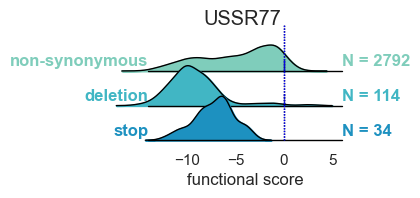

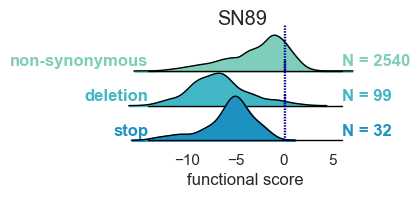

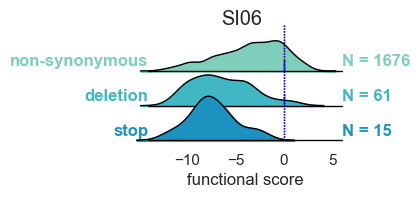

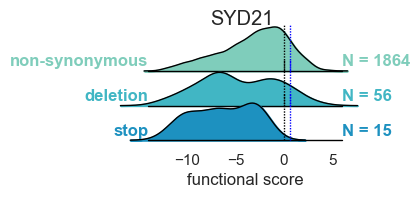

In [27]:
#FILTERED DATA this generates the distirbution plots of functional scores by virus background and mutation type

background_list=['USSR77','SN89','SI06','SYD21']
smoothing_factor = 0.8 #lower the number, the less smoothing, this is a float
aspect_ratio = 5 #essentially controls width/length of plots, higher number is wider
difference_filter = 3

for bkg in background_list:

    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    # Create the data
    df = func_score_reps.query(f"condition=='{bkg}' & mut_type!='synonymous' & mut_type!='multi_mut' & difference <= {difference_filter}")
    
    # get synonymous mutations functional score
    syn_func_score = func_score_reps.query(f"condition == '{bkg}' & mut_type == 'synonymous' ")['func_score'].iat[0]
    
    # Get counts of each mut type
    non_syn_counts = func_score_reps.query(f"condition == '{bkg}' & mut_type == 'non-synonymous' & difference <= {difference_filter}")['aa_substitutions'].nunique()
    deletion_counts = func_score_reps.query(f"condition == '{bkg}' & mut_type == 'deletion' & difference <= {difference_filter}")['aa_substitutions'].nunique()
    stop_counts = func_score_reps.query(f"condition == '{bkg}' & mut_type == 'stop' & difference <= {difference_filter}")['aa_substitutions'].nunique()

    # Initialize the FacetGrid object
    pal = ['#7fcdbb','#41b6c4','#1d91c0']
    df = df.rename(columns={'func_score':'functional score'})
    #pal = sns.cubehelix_palette(10, rot=-.25, light=.4)
    g = sns.FacetGrid(df, row="mut_type", row_order=['non-synonymous','deletion','stop'],
                      hue='mut_type', hue_order = ['non-synonymous','deletion','stop'],
                      aspect=aspect_ratio, height=.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "functional score",
          bw_adjust=smoothing_factor, clip_on=False,
          fill=True, alpha=1, linewidth=1.5, common_norm=False)
    g.map(sns.kdeplot, "functional score", clip_on=False, color="black", lw=1, bw_adjust=smoothing_factor)

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=1, linestyle="-", color='black', clip_on=False)
    g.refline(x=0, linewidth=1, linestyle="-", color='black', clip_on=False, dashes=(1,1))
    g.refline(x=syn_func_score,linewidth=1, linestyle="-", color='blue', clip_on=False, dashes=(1,1))



    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="right", va="center", transform=ax.transAxes)

        
    

    g.map(label, "functional score")
    #g.map(label_n, "func_score")
    
    ax = plt.gca()
    hplacement = 1
    ax.text(hplacement, 1.7, f"N = {non_syn_counts}", fontweight="bold", color=pal[0],
                ha="left", va="center", transform=ax.transAxes)
    ax.text(hplacement, 0.95, f"N = {deletion_counts}", fontweight="bold", color=pal[1],
                ha="left", va="center", transform=ax.transAxes)
    ax.text(hplacement, 0.2, f"N = {stop_counts}", fontweight="bold", color=pal[2],
                ha="left", va="center", transform=ax.transAxes)

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-0.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)
    g.savefig(f'plots/{bkg}_func_score_distribution_plot_filtered.png')
    g.fig.suptitle(bkg)
    g.set(xlim=(-14, 6))

In [28]:
aa_list = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y','-']
mut_list = []
position = '157'
for aa in aa_list:
    mut = position+aa
    mut_list.append(mut)

In [31]:
#selected for differences bewtween USSR77, SN89, and SI06 (not SYD21)
mut_list_1 = ['131D','212T','217R','225G','225R','226L','226V','226R','227A','227H','140P','193E','158T','158H','142L','142Q','145A','133G','156E']

#selected for differences bewtween SI06 and SYD21
mut_list_2 = ['209E','132S','163Y','137T','137E','137N','156E','156-','158T','159D','159E','159F','159I','159K','159P','159S','159V','159Y']

mut_list = mut_list_1 + mut_list_2

pos_159_list = ['159G','159D','159E','159F','159I','159K','159P','159S','159V','159Y']

loop_220_list = ['225G','225R','226L','226V','226R','227A','227H']

loop_150_list_no_159 = ['156E','156-','158T','158G']

n_gly_list = ['212T']

test_list = ['172W','192S','159E']

recombinant_variants = ['189D','193D','159E','190I','190Q','193F','166A','171W','128D','166L','193K','145R']



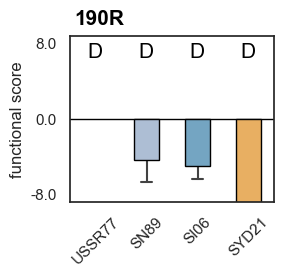

In [35]:
#plot manually queried bar plots for specific mutations or mutation lists
mutation_list=['190R']
background_list=['USSR77','SN89','SI06','SYD21']

lower_bound = -8
upper_bound = 8

limits = [lower_bound+lower_bound/10, upper_bound+upper_bound/10]
ticks = np.linspace(lower_bound, upper_bound, (abs(lower_bound)+upper_bound-1)%4)

pal = ['#d0d1e6','#a6bddb','#67a9cf','#feb24c']

for mut in mutation_list:
    #get mut res
    mut_res = mut[-1:]
    pos = mut[0:-1]
    
    #get wildtype aas at the position
    if pos == '600':
        wt_aa_ussr77 = wt_aa_df.query(f"condition == 'USSR77' & reference_site == {pos}")['wt_aa'].iat[0]
        wt_aa_sn89 = wt_aa_df.query(f"condition == 'SN89' & reference_site == {pos}")['wt_aa'].iat[0]
        wt_aa_syd21 = wt_aa_df.query(f"condition == 'SYD21' & reference_site == {pos}")['wt_aa'].iat[0]
    
        wt_dict={'USSR77':wt_aa_ussr77,
                 'SN89':wt_aa_sn89,
                 'SYD21':wt_aa_syd21}
        
        background_list = ['USSR77','SN89','SYD21']
    else:
        wt_aa_ussr77 = wt_aa_df.query(f"condition == 'USSR77' & reference_site == {pos}")['wt_aa'].iat[0]
        wt_aa_sn89 = wt_aa_df.query(f"condition == 'SN89' & reference_site == {pos}")['wt_aa'].iat[0]
        wt_aa_si06 = wt_aa_df.query(f"condition == 'SI06' & reference_site == {pos}")['wt_aa'].iat[0]
        wt_aa_syd21 = wt_aa_df.query(f"condition == 'SYD21' & reference_site == {pos}")['wt_aa'].iat[0]
    
        wt_dict={'USSR77':wt_aa_ussr77,
                 'SN89':wt_aa_sn89,
                 'SI06':wt_aa_si06,
                 'SYD21':wt_aa_syd21}
    
    #get data for mut
    df = pd.DataFrame()
    for bkg in background_list:
        wt_bkg_res = wt_dict[bkg]
        if mut_res != wt_bkg_res:
            temp_df = func_score_singles.query(f"condition == '{bkg}' & mut == '{mut}' & replicate != 'all' ")
        if mut_res == wt_bkg_res:
            temp_df = func_score_singles.query(f"condition == '{bkg}' & mut_type == 'syn' & replicate != 'all' ")
        df = pd.concat([df, temp_df])
    
    #make plot
    plt.figure(figsize=(3, 3))
    plt.xticks(rotation=45)
    g = sns.barplot(data=df, x='condition', y='func_score',width=0.5, 
                    errorbar='se', capsize=0.2, errwidth = 1.5,
                    order=['USSR77','SN89','SI06','SYD21'],
                    palette=pal, edgecolor='black', zorder=2.5, linewidth=1)
    ax = plt.gca()
    ax.text(.02, 1.1, mut, fontweight="bold", color='black', fontsize =15,
                ha="left", va="center", transform=ax.transAxes)
    first_hspace=.12
    ax.text(first_hspace, 0.9, wt_aa_ussr77, color='black', fontsize =15,
                ha="center", va="center", transform=ax.transAxes)
    ax.text(first_hspace+1*0.25, 0.9, wt_aa_sn89, color='black', fontsize =15,
                ha="center", va="center", transform=ax.transAxes)
    ax.text(first_hspace+2*0.25, 0.9, wt_aa_si06, color='black', fontsize =15,
                ha="center", va="center", transform=ax.transAxes)
    ax.text(first_hspace+3*0.25, 0.9, wt_aa_syd21, color='black', fontsize =15,
                ha="center", va="center", transform=ax.transAxes)
    
    ax.set_yticks(ticks, labels=ticks)
    
    ax.set_ylim(limits)
    ax.set(xlabel='', ylabel='functional score')
    
    g.axhline(y=0,color='black',linewidth=1)
    plt.tight_layout()
    
    g.figure.savefig(f'plots/func_score_differences/{mut}_func_score_differences.png')
    plt.show()

In [20]:
#get wt sequences at reference positions and store in dataframe

#wildtype sequences, note that sn89 starts later due to the salI cut site being partway through the HA but before the mutated region
geneseq_ussr = 'ATGAAAGCAAAACTACTGGTCCTGTTATGTGCACTTTCAGCTACAGATGCAGACACAATATGTATAGGCTACCATGCGAACAACTCAACCGACACTGTTGACACAGTACTCGAAAAGAACGTGACAGTGACACACTCTGTCAACCTACTTGAGGACAGTCACAACGGAAAACTATGCAGACTAAAAGGAATAGCCCCACTACAATTGGGGAAATGCAACATTGCCGGATGGATCTTAGGAAACCCAGAATGCGAATCACTGTTTTCTAAGAAATCATGGTCCTACATTGCAGAAACACCAAACTCCGAGAATGGAACATGTTACCCAGGATATTTCGCCGACTATGAGGAATTGAGGGAGCAATTGAGCTCAGTATCATCATTCGAGAGATTCGAAATATTCCCCAAGGAAAGATCATGGCCCAAACACAACGTAACCAGAGGCGTAACGGCATCATGCTCCCATAAGGGGAAAAGCAGTTTTTACAGAAATTTGCTATGGCTGACGGAGAAAAATGGCTCGTACCCAAATCTGAGCAAGTCCTATGTGAACAACAAAGAGAAAGAAGTCCTTGTACTATGGGGTGTTCATCACCCGTCAAACATAGAGGACCAAAAGACCATCTATCGGAAAGAAAATGCTTATGTGTCTGTAGTGTCTTCAAATTATAACAGGAGATTCACCCCAGAAATAGCAGAAAGACCCAAAGTAAGAGGTCAAGCAGGGAGAATTAACTACTACTGGACTCTGCTGGAACCCGGGGACACAATAATATTTGAGGCAAATGGAAATCTAATAGCGCCATGGCATGCTTTCGCACTGAATAGAGGCTTTGGGTCAGGAATCATCACCTCAAACGCATCGATGGATGAATGTGACACGAAGTGTCAAACACCCCAGGGAGCTATAAACAGTAGTCTTCCTTTCCAGAATATACACCCAGTCACAATAGGGGAGTGCCCAAAATACGTCAGGAGTACAAAATTGAGGATGGTTACAGGACTAAGGAACATCCCATCCATTCAATCCAGAGGTCTGTTTGGAGCCATTGCCGGTTTCATTGAAGGGGGATGGACTGGAATGATAGATGGATGGTATGGTTATCATCATCAGAATGAACAGGGATCTGGCTATGCTGCGGATCAAAAAAGCACACAAAATGCCATTAACGGGATTACAAACAAGGTGAACTCTGTTATCGAGAAAATGAACACTCAATTCACAGCTGTGGGTAAAGAATTCAACAAATTAGAAAAAAGGATGGAAAACTTAAATAAAAAAGTTGATGATGGATTTCTGGACATTTGGACATATAATGCAGAATTGTTGGTTCTACTGGAAAATGAAAGGACTTTGGATTTTCATGACTCAAATGTGAAGAATCTGTATGAGAAAGTAAAAAGCCAATTAAAGAATAATGCCAAAGAAATAGGAAACGGGTGTTTTGAATTCTACCACAAGTGTAACAATGAATGCATGGAAAGTGTAAAAAATGGAACTTATGACTATCCAAAATATTCAGAGGAATCAAAGTTAAACAGGGAAAAAATTGATGGAGTGAAATTGGAATCAATGGGAGTCTATCAGATTCTGGCGATCTACTCAACTGTCGCCAGTTCACTGGTCCTGCTCGTGTCACTGGGAGCCATCAGCTTCTGGATGTGCAGCAACGGCAGCCTCCAGTGTAGGATTTGCATTTAA'
geneseq_sn = 'GCCCCACTACAATTGGGTAATTGCAGCATTGCCGGATGGATCTTAGGAAACCCAGAATGCGAATCACTGTTTTCTAAGGAATCATGGTCCTACATTGCAGAAACACCAAACTCCGAGAATGGAACATGTTACCCAGGGTATTTCGCCGACTATGAGGAACTGAGGGAGCAATTGAGTTCAGTATCATCATTCGAGAGATTCGAAATATTCCCCAAAGAAAGCTCATGGCCCAACCACACCGTAACCAAAGGAGTAACGGCAGCATGCTCCCATAATGGGAAAAGCAGTTTTTACAGAAATTTGCTATGGCTGACGGAGAAGAATGGCTTGTACCCAAATCTGAGCAAGTCCTATGTAAACAACAAAGAGAAAGAAGTCCTTGTACTATGGGGTGTTCATCACCCGTCAAACATAGGGGACCAAAGGGCCATCTATCATACAGAAAATGCTTATGTGTCTGTAGTGTCTTCACATTATAGCAGGAGATTCACCCCAGAAATAGCAAAAAGACCCAAAGTAAGAGGTCAAGAAGGAAGAATTAACTACTACTGGACTCTGCTGGAACCCGGGGACACAATAATATTTGAGGCAAATGGAAATCTAATAGCGCCATGGTATGCTTTCGCACTGAGTAGAGGCTTTGGGTCAGGAATCATCACCTCAAACGCATCAATGGATGAATGTGACGCGAAGTGTCAAACACCCCAGGGAGCTATAAACAGTAGTCTTCCTTTCCAGAATGTACACCCAGTCACAATAGGAGAGTGTCCAAAGTATGTCAGGAGTACAAAATTAAGGATGGTTACAGGACTAAGGAACATCCCATCCGTTCAATCCAGAGGTTTGTTTGGAGCCATTGCCGGTTTCATTGAAGGGGGGTGGACTGGAATGATAGATGGATGGTATGGTTATCATCATCAAAATGAACAAGGATCTGGCTATGCTGCGGATCAAAAAAGCACACAAAATGCCATTAACGGGATTACAAACAAGGTGAATTCTGTAATCGAGAAAATGAACACTCAATTCACAGCTGTGGGCAAAGAATTCAACAAATTAGAAAGAAGGATGGAAAACTTAAATAAAAAAGTTGATGATGGATTTCTGGACATTTGGACATATAATGCAGAATTGTTGGTTCTACTGGAAAATGAAAGGACTTTGGATTTTCATGACTCAAATGTGAAGAATCTGTATGAGAAAGTAAAAAGCCAATTAAAGAATAATGCCAAAGAAATAGGAAACGGGTGTTTTGAATTCTACCACAAGTGTAACAATGAATGCATGGAAAGTGTGAAAAATGGAACTTATGACTATCCAAAATATTCCGAGGAATCAAAGTTAAACAGGGAAAAAATTGATGGAGTGAAATTGGAATCAATGGGAGTCTATCAGATTCTGGCGATCTACTCAACTGTCGCCAGTTCACTGGTCCTGCTCGTGTCACTGGGAGCCATCAGCTTCTGGATGTGCAGCAACGGCAGCCTCCAGTGTAGGATTTGCATTTAA'
geneseq_si = 'ATGAAAGTAAAACTACTGGTTCTGTTATGCACATTTACAGCTACATATGCAGACACAATATGTATAGGCTACCATGCCAACAACTCAACCGACACTGTTGACACAGTACTTGAGAAGAATGTGACAGTGACACACTCTGTCAACCTGCTTGAGGACAGTCACAATGGAAAATTATGTCTATTAAAAGGAATAGCCCCACTACAATTGGGTAATTGCAGCGTTGCCGGATGGATCTTAGGAAACCCAGAATGCGAATTACTGATTTCCAGGGAATCATGGTCCTACATTGTAGAAAAACCAAATCCTGAGAATGGAACATGTTACCCAGGGCATTTCGCCGACTATGAGGAACTGAGGGAGCAATTGAGTTCAGTATCTTCATTTGAGAGATTCGAAATATTCCCCAAAGAAAGCTCATGGCCCAACCACACCACAACCGGAGTATCAGCATCATGCTCCCATAATGGGGAAAGCAGTTTTTACAAAAATTTGCTATGGCTGACGGGGAAGAATGGTTTGTACCCAAACCTGAGCAAGTCCTATGCAAACAACAAAGAGAAAGAAGTCCTTGTACTATGGGGTGTTCATCACCCGCCTAACATAGGTGACCAAAGGGCTCTCTATCATACAGAAAATGCTTATGTGTCTGTAGTGTCTTCACATTATAGCAGAAAATTCACCCCAGAAATAGCCAAAAGACCCAAAGTAAGAGATCAAGAAGGAAGAATCAACTACTACTGGACTCTACTTGAACCCGGGGATACAATAATATTTGAGGCAAATGGAAATCTAATAGCGCCAAGATATGCTTTCGCACTGAGTAGAGGCTTTGGATCAGGAATCATCAACTCAAATGCACCAATGGATGAATGTGATGCGAAGTGCCAAACACCTCAGGGAGCTATAAACAGCAGTCTTCCTTTCCAGAATGTACACCCTGTCACAATAGGAGAGTGTCCAAAGTATGTCAGGAGTGCAAAATTAAGGATGGTTACAGGACTAAGGAACATCCCATCCATTCAATCCAGAGGTTTGTTTGGAGCCATTGCCGGTTTCATTGAAGGGGGGTGGACTGGAATGGTAGATGGTTGGTATGGTTATCATCATCAGAATGAGCAAGGATCTGGCTATGCTGCAGATCAAAAAAGCACACAAAATGCCATTAATGGGATTACAAACAAGGTGAATTCTGTAATTGAGAAAATGAACACTCAATTCACAGCTGTGGGCAAAGAATTCAACAAATTGGAAAGAAGGATGGAAAACTTAAATAAAAAAGTTGATGATGGGTTTATAGACATTTGGACATATAATGCAGAATTGTTGGTTCTACTGGAAAATGAAAGGACTTTGGATTTCCATGACTCCAATGTGAAGAATCTGTATGAGAAAGTAAAAAGCCAATTAAAGAATAATGCCAAAGAAATAGGAAATGGGTGTTTTGAATTCTATCACAAGTGTAACGATGAATGCATGGAGAGTGTAAAAAATGGAACTTATGACTATCCAAAATATTCCGAAGAATCAAAGTTAAACAGGGAGAAAATTGATGGAGTGAAATTGGAATCAATGGGAGTCTATCAGATTCTGGCGATCTACTCAACAGTCGCCAGTTCTCTGGTCCTGCTCGTGTCACTGGGAGCCATCAGCTTCTGGATGTGCAGCAACGGCAGCCTCCAGTGTAGGATTTGCATTTAA'
geneseq_syd = 'ATGAAGGCAATACTAGTAGTTATGCTGTATACATTTACAACCGCAAATGCAGACACATTATGTATAGGTTATCATGCGAACAATTCAACAGACACTGTGGACACAGTACTAGAAAAGAATGTAACAGTAACACACTCTGTCAATCTTCTAGAAGACAAGCATAACGGAAAACTATGCAAACTAAGAGGGGTAGCCCCATTGCATTTGGGTCAATGTAACATTGCTGGCTGGATCCTGGGAAATCCAGAGTGTGAATCACTCTCCACAGCAAGATCATGGTCCTACATTGTGGAAACATCTAATTCAGACAATGGAACGTGTTACCCAGGAAATTTCATCAATTATGAGGAGCTAAGAGAGCAATTGAGCTCAGTGTCATCATTTGAAAGGTTTGAAATATTCCCCAAGACAAGTTCATGGCCTAATCATGACTCGGACAATGGTGTAACGGCAGCATGTCCTCACGCTGGAGCAAAAAGCTTCTACAAAAACTTGATATGGCTGGTTAAAAAAGGAAAATCATACCCAAAGATCAACCAAACCTACATTAATGATAAAGGGAAAGAAGTCCTCGTGCTGTGGGGCATTCACCATCCACCTACTATTACTGACCAAGAAAGTCTCTATCAGAATGCAGATGCATATGTTTTTGTGGGGACATCAAGATACAGCAAGAAGTTCAAGCCGGAAATAGCAGCAAGACCCAAAGTGAGGGATCAAGCAGGGAGAATGAACTATTACTGGACACTAGTAGAACCGGGAGATAAAATAACATTCGAAGCAACTGGTAATCTAGTGGCACCGAGATATGCATTCACAATGGAAAAAGATGCTGGATCTGGTATTATCATTTCAGATACACCAGTCCACGATTGCAATACAACTTGTCAGACACCCGAGGGTGCTATAAACACCAGCCTCCCATTTCAGAATGTACATCCGATCACGATTGGGAAATGTCCAAAGTATGTAAGAAGCACAAAATTGAGACTGGCCACAGGATTGAGGAATGTCCCGTCTATTCAATCTAGAGGCCTATTCGGGGCCATTGCTGGCTTCATCGAAGGGGGGTGGACAGGGATGGTAGATGGATGGTACGGTTATCACCATCAAAATGAGCAGGGGTCAGGATATGCAGCCGATCTGAAGAGCACACAAAATGCCATTGATAAGATTACCAACAAAGTAAATTCTGTCATTGAAAAGATGAATACACAGTTCACAGCAGTTGGTAAAGAGTTCAACCACCTTGAAAAAAGAATAGAGAATCTAAATAAAAAGGTTGATGATGGTTTCCTGGACATTTGGACTTACAATGCCGAACTGTTGGTTCTACTGGAAAACGAAAGAACTTTGGACTATCACGATTCAAATGTGAAGAACTTGTATGAAAAAGTAAGAAACCAGTTAAAAAACAATGCCAAGGAAATTGGAAACGGCTGCTTTGAATTTTACCACAAATGCGACAACACATGCATGGAAAGTGTCAAGAATGGGACTTATGACTACCCAAAATACTCAGAGGAAGCAAAATTAAACAGAGAAAAAATAGATGGAGTAAAGCTGGACTCAACAAGGATTTACCAGATTTTGGCAATCTATTCAACTGTTGCCAGTTCATTGGTCCTGGTCGTGTCACTGGGAGCCATCAGCTTCTGGATGTGCAGCAACGGCAGCCTCCAGTGTAGGATTTGCATTTAA'

geneseq_dict = {'USSR77':geneseq_ussr,
                'SN89':geneseq_sn,
                'SI06':geneseq_si,
                'SYD21':geneseq_syd}

nucleotides = ['A','T','C','G']
all_codons = itertools.product(nucleotides, repeat = 3)
all_codons = [''.join(i) for i in itertools.product(nucleotides, repeat = 3)]

condition_list = []
wt_codon_list = []
sequential_position_list = []
wt_aa_list = []
single_nt_mut_list = []
double_nt_mut_list = []
triple_nt_mut_list = []
single_nt_aa_muts_list = []
double_nt_aa_muts_list = []
triple_nt_aa_muts_list = []

def get_codon_distances(codon):
    
    delta_dict={1:[],
                2:[],
                3:[]}

    for cdn in all_codons:
        if cdn == codon:
            continue
        else:
            count = sum(1 for a, b in zip(codon, cdn) if a != b)
            delta_dict[count].append(cdn)
            
    return delta_dict

def get_mut_aas(delta_dict):
    
    aa_delta_dict={1:[],
                   2:[],
                   3:[]}
    
    for x in [1,2,3]:
        codons = delta_dict[x]
        for cdn in codons:
            mut_aa = str(Seq(cdn).translate())
            aa_delta_dict[x].append(mut_aa)

    return aa_delta_dict

nsubs_df = pd.DataFrame()

for bkg in geneseq_dict:
    wt_nt_seq = Seq(geneseq_dict[bkg])
    for pos in range(int(len(wt_nt_seq)/3)):
        
        codon_pos = pos * 3
        wt_codon = wt_nt_seq[codon_pos:codon_pos+3]
        wt_aa = Seq(wt_codon).translate()
        
        mut_codons = get_codon_distances(wt_codon)
        mut_aas = get_mut_aas(mut_codons)
        
        single_nt_mut_list.append(mut_codons[1])
        double_nt_mut_list.append(mut_codons[2])
        triple_nt_mut_list.append(mut_codons[3])
        
        single_nt_aa_muts_list.append(mut_aas[1])
        double_nt_aa_muts_list.append(mut_aas[2])
        triple_nt_aa_muts_list.append(mut_aas[3])
        
        condition_list.append(bkg)
        wt_codon_list.append(str(wt_codon))
        wt_aa_list.append(str(wt_aa))
        sequential_position_list.append(pos+1)


nsubs_df['condition']=condition_list
nsubs_df['wt_codon']=wt_codon_list
nsubs_df['sequential_site']=sequential_position_list
nsubs_df['wt_aa'] = wt_aa_list
nsubs_df['single_nt_mut'] = single_nt_mut_list
nsubs_df['double_nt_mut'] = double_nt_mut_list
nsubs_df['triple_nt_mut'] = triple_nt_mut_list
nsubs_df['single_nt_aa_mut'] = single_nt_aa_muts_list
nsubs_df['double_nt_aa_mut'] = double_nt_aa_muts_list
nsubs_df['triple_nt_aa_mut'] = triple_nt_aa_muts_list

background_list=['USSR77','SN89','SI06','SYD21']

renumber_df = pd.DataFrame()

for bkg in background_list:
    temp_df = pd.read_csv(f'data/renumbering_files/{bkg}_renumber.csv')
    temp_df['condition'] = bkg
    cols = ['condition','sequential_site','reference_site']
    temp_df = temp_df[cols]
    renumber_df = pd.concat([renumber_df,temp_df])
    
nsubs_df = nsubs_df.merge(renumber_df,on=['condition','sequential_site'],how='inner')
nsubs_df.head()

,condition,wt_codon,sequential_site,wt_aa,single_nt_mut,double_nt_mut,triple_nt_mut,single_nt_aa_mut,double_nt_aa_mut,triple_nt_aa_mut,reference_site
0,USSR77,ATG,1,M,"[AAG, ATA, ATT, ATC, ACG, AGG, TTG, CTG, GTG]","[AAA, AAT, AAC, ACA, ACT, ACC, AGA, AGT, AGC, ...","[TAA, TAT, TAC, TCA, TCT, TCC, TGA, TGT, TGC, ...","[K, I, I, I, T, R, L, L, V]","[K, N, N, T, T, T, R, S, S, *, L, F, F, S, W, ...","[*, Y, Y, S, S, S, *, C, C, Q, H, H, P, P, P, ...",-12
1,USSR77,AAA,2,K,"[AAT, AAC, AAG, ATA, ACA, AGA, TAA, CAA, GAA]","[ATT, ATC, ATG, ACT, ACC, ACG, AGT, AGC, AGG, ...","[TTT, TTC, TTG, TCT, TCC, TCG, TGT, TGC, TGG, ...","[N, N, K, I, T, R, *, Q, E]","[I, I, M, T, T, T, S, S, R, Y, Y, *, L, S, *, ...","[F, F, L, S, S, S, C, C, W, L, L, L, P, P, P, ...",-11
2,USSR77,GCA,3,A,"[ACA, TCA, CCA, GAA, GTA, GCT, GCC, GCG, GGA]","[AAA, ATA, ACT, ACC, ACG, AGA, TAA, TTA, TCT, ...","[AAT, AAC, AAG, ATT, ATC, ATG, AGT, AGC, AGG, ...","[T, S, P, E, V, A, A, A, G]","[K, I, T, T, T, R, *, L, S, S, S, *, Q, L, P, ...","[N, N, K, I, I, M, S, S, R, Y, Y, *, F, F, L, ...",-10
3,USSR77,AAA,4,K,"[AAT, AAC, AAG, ATA, ACA, AGA, TAA, CAA, GAA]","[ATT, ATC, ATG, ACT, ACC, ACG, AGT, AGC, AGG, ...","[TTT, TTC, TTG, TCT, TCC, TCG, TGT, TGC, TGG, ...","[N, N, K, I, T, R, *, Q, E]","[I, I, M, T, T, T, S, S, R, Y, Y, *, L, S, *, ...","[F, F, L, S, S, S, C, C, W, L, L, L, P, P, P, ...",-9
4,USSR77,CTA,5,L,"[ATA, TTA, CAA, CTT, CTC, CTG, CCA, CGA, GTA]","[AAA, ATT, ATC, ATG, ACA, AGA, TAA, TTT, TTC, ...","[AAT, AAC, AAG, ACT, ACC, ACG, AGT, AGC, AGG, ...","[I, L, Q, L, L, L, P, R, V]","[K, I, I, M, T, R, *, F, F, L, S, *, H, H, Q, ...","[N, N, K, T, T, T, S, S, R, Y, Y, *, S, S, S, ...",-8


In [269]:
#query 
def query_accessible_mutation(mut,bkgs = all):
    output_df = pd.DataFrame()
    nuc_sub_list = []
    output_dict = {'mutation':[{mut:[]}]}
    pos = mut[0:-1]
    mut_aa = mut[-1:]
    if bkgs == all:
        background_list = ['USSR77','SN89','SI06','SYD21']
    if bkgs != all:
        background_list = []
        background_list.append(bkgs)
    for bkg in background_list:
        df = nsubs_df.query(f" reference_site == {pos} & condition == '{bkg}' ")
        if mut_aa == df['wt_aa'].iat[0]:
            output_dict['mutation'][0][mut].append(0)
            output_df['mutation'] = mut
            nuc_sub_list.append(0)
            #print(bkg, 'wt')
            continue
        for mutant in df['single_nt_aa_mut'].iat[0]:
            if mut_aa == mutant:
                output_dict['mutation'][0][mut].append(1)
                output_df['mutation'] = mut
                nuc_sub_list.append(1)
                #print(bkg, 'single')
                break
        for mutant in df['double_nt_aa_mut'].iat[0]:
            if mut_aa == mutant:
                output_dict['mutation'][0][mut].append(2)
                output_df['mutation'] = mut
                nuc_sub_list.append(2)
                #print(bkg, 'double')
                break
        for mutant in df['triple_nt_aa_mut'].iat[0]:
            if mut_aa == mutant:
                output_dict['mutation'][0][mut].append(3)
                output_df['mutation'] = mut
                nuc_sub_list.append(3)
                #print(bkg, 'triple')
                break
    
    output_df['nuc_subs']=nuc_sub_list
    output_df['min_nuc_subs']=min(nuc_sub_list)
    output_df['mutation']=mut
    
    
    return output_df
    
    #output_df = pd.DataFrame.from_dict(output_dict)
    
    #return output_df


In [ ]:
mut_list = ('F R Y L W E V').split()
mut_list = ["171" + x for x in mut_list]
mut_list

pos_list = [145,156,159,189,190,192,193]
#pos_list = [126, 128, 166, 169, 171, 173]
aa_list = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']

pos_aa_list=[]
for pos in pos_list:
    for aa in aa_list:
        pos_aa_list.append(f"{pos}{aa}")
        
test_list = ['145D','193T','190D']

In [ ]:
b = 'SN89'
df=pd.DataFrame()
for m in pos_aa_list:
    temp = query_accessible_mutation(mut=m,bkgs=b)
    df_temp = pd.DataFrame.from_dict(temp)
    df = pd.concat([df,df_temp])
    df = df.drop(columns=['nuc_subs']).drop_duplicates()

df['position'] = df['mutation'].str[0:-1]
df['mut_aa'] = df['mutation'].str[-1:]

pivot = df.pivot_table(index='position',columns='mut_aa',values='min_nuc_subs').reset_index()

pivot.to_csv(f'min_nuc_subs_{b}_RBS.csv')

In [ ]:
df

,mutation,min_nuc_subs
0,600A,2
0,600C,3
0,600D,2
0,600E,1
0,600F,3
...,...,...
0,193S,1
0,193T,1
0,193V,1
0,193W,3


In [ ]:
query_accessible_mutation(mut='171A',bkgs='SN89')

{'nuc_subs': 2}